# Sprawozdanie 2
## Jakub Ciągło (275986), Mateusz Ćwiek (276011)

___
# Importy

In [1]:
from scipy import stats 
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportion_confint
import math
import matplotlib.pyplot as plt

___
# Część 1
## Zadanie 1
**Oszacowanie rozkładu opinii o szkoleniu – przedziały ufności dla wektora prawdopodobieństw** 

W zadaniu analizujemy odpowiedzi 200 pracowników, którzy oceniali szkolenie „Efektywna komunikacja w zespole”. Opinie zostały pogrupowane w pięć kategorii:  

Na podstawie uzyskanych liczebności wyznaczamy przedziały ufności dla częstości odpowiedzi w każdej kategorii, traktując te częstości jako estymacje elementów wektora prawdopodobieństw dyskretnego rozkładu opinii.  

Uwzględniamy dwa podejścia:  
- Dokładne przedziały Cloppera-Pearsona oparte na rozkładzie beta,  
- Przybliżone przedziały Wilsona (asymptotyczne).  

Ze względu na pięć kategorii, poziom ufności dla każdej z nich został skorygowany metodą Bonferroniego (czyli poziom istotności $ \alpha = 0.05 $ podzielono przez $5$).  

Przedziały zostały wyznaczone niezależnie dla każdej kategorii, zakładając próbę o stałej liczebności $ n = 200 $.

In [2]:
def clopper_pearson_ci(successes, trials, alpha):
    lower = stats.beta.ppf(alpha / 2, successes, trials - successes + 1)
    upper = stats.beta.ppf(1 - alpha / 2, successes + 1, trials - successes)
    return lower, upper

def wyznacz_przedzialy_ufnosci(liczebnosci, alpha=0.05):
    n = np.sum(liczebnosci)
    kategorie = len(liczebnosci)
    
    adjusted_alpha = alpha / kategorie

    przedzialy = []

    for i, sukcesy in enumerate(liczebnosci):
        cp_lower, cp_upper = clopper_pearson_ci(sukcesy, n, adjusted_alpha)

        wilson_lower, wilson_upper = proportion_confint(sukcesy, n, alpha=adjusted_alpha, method='wilson')

        przedzialy.append({
            'kategoria': i + 1,
            'dokladny': (cp_lower, cp_upper),
            'asymptotyczny': (wilson_lower, wilson_upper)
        })

    return przedzialy

liczebnosci = np.array([14, 17, 40, 100, 29])
przedzialy = wyznacz_przedzialy_ufnosci(liczebnosci, alpha=0.05)

for przedzial in przedzialy:
    print(f"Kategoria {przedzial['kategoria']}")
    print(f"  Metoda Clopper-Pearson: ({przedzial['dokladny'][0]:.3f}, {przedzial['dokladny'][1]:.3f})")
    print(f"  Metoda Wilson:          ({przedzial['asymptotyczny'][0]:.3f}, {przedzial['asymptotyczny'][1]:.3f})\n")


Kategoria 1
  Metoda Clopper-Pearson: (0.032, 0.130)
  Metoda Wilson:          (0.036, 0.132)

Kategoria 2
  Metoda Clopper-Pearson: (0.042, 0.149)
  Metoda Wilson:          (0.047, 0.150)

Kategoria 3
  Metoda Clopper-Pearson: (0.133, 0.282)
  Metoda Wilson:          (0.137, 0.282)

Kategoria 4
  Metoda Clopper-Pearson: (0.407, 0.593)
  Metoda Wilson:          (0.410, 0.590)

Kategoria 5
  Metoda Clopper-Pearson: (0.087, 0.220)
  Metoda Wilson:          (0.092, 0.221)



___
## Zadanie 2
**Poziomy krytyczne w testach dopasowania rozkładu – testy chi-kwadrat**

Celem zadania było stworzenie funkcji obliczającej poziomy krytyczne (p-value) w dwóch klasycznych testach dopasowania rozkładu wielomianowego:

- Test chi-kwadrat Pearsona,  
- Test chi-kwadrat największej wiarygodności.

Weryfikujemy hipotezę:
$$
H_0: \mathbf{p} = \mathbf{p}_0 \quad \text{przeciwko} \quad H_1: \mathbf{p} \ne \mathbf{p}_0
$$
na podstawie obserwacji $\mathbf{x} = (x_1, \dots, x_k)$ będącej realizacją zmiennej losowej z rozkładu wielomianowego o parametrach $n$ (łączna liczba prób) i $\mathbf{p}$.

W funkcji:

- Obliczono wartość statystyki testowej Pearsona:  
  $$
  \chi^2 = \sum_{i=1}^k \frac{(x_i - np_{0i})^2}{np_{0i}}
  $$
- Obliczono statystykę testu największej wiarygodności:  
  $$
  G^2 = 2 \sum_{i=1}^k x_i \log \left( \frac{x_i}{np_{0i}} \right)
  $$
- Dla obu statystyk zwrócono wartość p-value obliczoną na podstawie rozkładu $\chi^2$ z $k - 1$ stopniami swobody.  

Funkcja przyjmuje dowolny rozkład teoretyczny $\mathbf{p}_0$ i zestaw danych $\mathbf{x}$, co pozwala łatwo porównywać dane empiryczne z dowolną hipotezą dotyczącą struktury rozkładu.

In [3]:
def poziomy_krytyczne(x, p_0):
    k = len(p_0)
    n = sum(x)
    
    pearson_stat = sum(((x[i] - n * p_0[i]) ** 2) / (n * p_0[i]) for i in range(k))

    nw_stat = 2 * sum(x[i] * np.log(x[i] / (n * p_0[i])) for i in range(k) if x[i] > 0)
    
    p_value_pearson = 1 - stats.chi2.cdf(pearson_stat, k - 1)
    p_value_nw = 1 - stats.chi2.cdf(nw_stat, k - 1)
    
    return float(p_value_pearson), float(p_value_nw)

___
## Zadanie 3

**Test zgodności rozkładu odpowiedzi z rozkładem jednostajnym — Dział Produktowy**

W tym zadaniu sprawdzono, czy rozkład odpowiedzi pracowników z Działu Produktowego na pytanie dotyczące wsparcia i materiałów szkoleniowych (PYT_1) można uznać za jednostajny, czyli czy każde z pięciu możliwych stanowisk (-2, -1, 0, 1, 2) było wybierane z jednakowym prawdopodobieństwem.

Do weryfikacji hipotezy:
$$
H_0: \text{rozkład odpowiedzi jest jednostajny (równe prawdopodobieństwa)} \\
H_1: \text{rozkład odpowiedzi nie jest jednostajny}
$$
wykorzystano dwie statystyki chi-kwadrat:

- **Test Pearsona**,  
- **Test największej wiarygodności**.

Na podstawie otrzymanych wartości p (p-value) z obu testów oceniono, czy istnieją podstawy do odrzucenia hipotezy zerowej na poziomie istotności $\alpha = 0.05$.  

In [4]:
alfa = 0.05
df = pd.read_csv('ankieta.csv', encoding='Latin2', sep=';')

df_produktowy = df[df['DZIAŁ'] == 'PD']

odpowiedzi = [-2, -1, 0, 1, 2]
n = df_produktowy['PYT_1'].value_counts().reindex(odpowiedzi, fill_value=0).tolist()
print('Liczności odpowiedzi:', n)

p_0 = [1/len(n) for _ in range(len(n))] # w hipotezie zakładamy, że prawdopodobieństwa są równe
p_value_pearson, p_value_nw = poziomy_krytyczne(n,p_0)

p_value_pearson, p_value_nw = poziomy_krytyczne(n, p_0)

print(f'Statystyka chi² Pearsona (dla poziomu istotności α = {alfa}):')
print(f'  p-wartość = {p_value_pearson}')
if p_value_pearson > alfa:
    print('  → Brak podstaw do odrzucenia hipotezy zerowej (rozkład może być równomierny)')
else:
    print('  → Odrzucamy hipotezę zerową (rozkład nie jest równomierny)')

print(f'\nStatystyka chi² największej wiarygodności (dla poziomu istotności α = {alfa}):')
print(f'  p-wartość = {p_value_nw}')
if p_value_nw > alfa:
    print('  → Brak podstaw do odrzucenia hipotezy zerowej (rozkład może być równomierny)')
else:
    print('  → Odrzucamy hipotezę zerową (rozkład nie jest równomierny)')

Liczności odpowiedzi: [9, 10, 17, 51, 11]
Statystyka chi² Pearsona (dla poziomu istotności α = 0.05):
  p-wartość = 2.757793993168889e-13
  → Odrzucamy hipotezę zerową (rozkład nie jest równomierny)

Statystyka chi² największej wiarygodności (dla poziomu istotności α = 0.05):
  p-wartość = 1.0701994845874196e-10
  → Odrzucamy hipotezę zerową (rozkład nie jest równomierny)


___
# Część II 
___
## Zadanie 4
**Zapoznanie się z funkcjami służącymi do wykonania testu Fishera oraz testu Freemana-Haltona.**


In [12]:
table_fisher = np.array([[10, 20], [10, 30]])

oddsratio, p_value_fisher = stats.fisher_exact(table_fisher)

print(f"Wynik testu Fishera: p-value = {p_value_fisher:.4f}")
if p_value_fisher < 0.05:
    print("→ ODRZUCAMY H₀: zmienne są zależne")
else:
    print("→ Brak podstaw do odrzucenia H₀: zmienne są niezależne")

table_freeman = np.array([[10, 20, 30], [5, 15, 25], [20, 30, 40]])

table_freeman_transposed = table_freeman.T

statistic, p_value_freeman = stats.friedmanchisquare(*table_freeman_transposed)


print(f"Wynik testu Freemana-Haltona: p-value = {p_value_freeman:.4f}")
if p_value_freeman < 0.05:
    print("→ ODRZUCAMY H₀: zmienne są zależne")
else:
    print("→ Brak podstaw do odrzucenia H₀: zmienne są niezależne")

Wynik testu Fishera: p-value = 0.5937
→ Brak podstaw do odrzucenia H₀: zmienne są niezależne
Wynik testu Freemana-Haltona: p-value = 0.0498
→ ODRZUCAMY H₀: zmienne są zależne


___
## Zadanie 5
**Test niezależności zmiennych "PŁEĆ" i "CZY_KIER" za pomocą testu Fishera**

W zadaniu przeprowadzono test niezależności dwóch zmiennych: **PŁEĆ** (kobieta/mężczyzna) i **CZY_KIER** (czy na stanowisku kierowniczym), aby sprawdzić, czy zmienne te są niezależne na poziomie istotności 0.05.

**Hipoteza zerowa (H0):** Zmienne "PŁEĆ" i "CZY_KIER" są niezależne.  
**Hipoteza alternatywna (H1):** Zmienne "PŁEĆ" i "CZY_KIER" są zależne.

Aby przeprowadzić test Fishera, stworzono tabelę kontyngencji 2x2, która pokazuje liczbę kobiet i mężczyzn na stanowiskach kierowniczych i niekierowniczych.

In [ ]:
contingency_table = pd.crosstab(df['PŁEĆ'], df['CZY_KIER'])
print(contingency_table)

oddsratio, p_value = stats.fisher_exact(contingency_table)

print("Wynik testu Fishera:")
print(f"  odds ratio: {oddsratio}")
print(f"  p-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Odrzucamy hipotezę zerową -> zmienne 'PŁEĆ' i 'CZY_KIER' są zależne.")
else:
    print("Brak podstaw do odrzucenia H0 -> nie ma dowodów na zależność.")


CZY_KIER  Nie  Tak
PŁEĆ              
K          63    8
M         110   19
Wynik testu Fishera:
  odds ratio: 1.3602272727272726
  p-value: 0.6659028889666552
Brak podstaw do odrzucenia H0 -> nie ma dowodów na zależność.


Jeśli p‑value < 0.05, odrzucamy hipotezę o niezależności, co oznacza, że istnieje istotna statystycznie różnica w prawdopodobieństwie bycia na stanowisku kierowniczym między kobietami a mężczyznami.

Jeśli p‑value ≥ 0.05 - tak jak w wyniku zadania, mamy brak podstaw do odrzucenia hipotezy zerowej, czyli test Fishera ($p = 0.6659$) nie wykazał istotnej różnicy między kobietami i mężczyznami w udziale stanowisk kierowniczych, co oznacza, że prawdopodobieństwo pełnienia funkcji kierowniczej jest w obu grupach statystycznie zbliżone.

___
## Zadanie 6
**Test Freemana-Haltona dla zależności między zmiennymi**

W zadaniu przeprowadzono testy zależności między różnymi zmiennymi w zestawie danych, wykorzystując test Freemana-Haltona. 

Dla każdej pary zmiennych wyliczono wartość p-testu Freemana-Haltona. Na poziomie istotności 0.05, jeśli p-wartość była mniejsza od 0.05, hipotezę zerową odrzucano, co wskazuje na zależność między badanymi zmiennymi. Jeśli p-wartość była większa lub równa 0.05, hipotezę zerową utrzymano, co oznacza brak dowodów na zależność.

Na końcu dla każdej zmiennej uzyskano decyzje dotyczące hipotez zerowych, przedstawiając wyniki testu Fishera dla odpowiednich par zmiennych.

In [130]:
import os
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.5.0"
os.environ["PATH"] += r";C:\Program Files\R\R-4.5.0\bin\x64"
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
stats = importr("stats") 

In [131]:
from rpy2.robjects import pandas2ri; pandas2ri.activate()

df["CZY_ZADOW"] = df["PYT_2"].replace({
    -2: "niezadowolony",
    -1: "niezadowolony",
     1: "zadowolony",
     2: "zadowolony"
})

df["WIEK_KAT"] = pd.cut(
        df["WIEK"],
        bins=[0, 35, 45, 55, float("inf")],
        labels=["do 35 lat", "36‑45 lat", "46‑55 lat", "powyżej 55 lat"])


def fisher_fh(tab, simulate=False, B=50000, workspace=300000):
    r_tab = pandas2ri.py2rpy(tab)
    res   = stats.fisher_test(
               r_tab,
               simulate_p_value = simulate,
               B        = B if simulate else 0,
               workspace = workspace if not simulate else None
           )
    return dict(res.items())["p.value"][0]


hipotezy = [
    ("CZY_KIER", "WIEK_KAT",  "a"),
    ("CZY_KIER", "STAŻ",    "b"),
    ("PYT_2",    "CZY_KIER",  "c"),
    ("PYT_2",    "STAŻ",    "d"),
    ("PYT_2",    "PŁEĆ",      "e"),
    ("PYT_2",    "WIEK_KAT",  "f"),
]

for x, y, et in hipotezy:
    tab = pd.crosstab(df[x], df[y])
    p   = fisher_fh(tab, simulate = tab.size > 25)
    decyzja = "ODRZUCAMY H₀" if p < 0.05 else "brak podstaw"
    print(f"{et}) {x} × {y:<9}  p = {p:6.4f}  → {decyzja}")

print("\n--- PYT_2 zastąpione przez CZY_ZADOW ---")
for x, y, et in [
        ("CZY_ZADOW", "CZY_KIER", "c′"),
        ("CZY_ZADOW", "STAŻ",   "d′"),
        ("CZY_ZADOW", "PŁEĆ",     "e′"),
        ("CZY_ZADOW", "WIEK_KAT", "f′")]:
    tab = pd.crosstab(df[x], df[y])
    p   = fisher_fh(tab, simulate = tab.size > 25)
    decyzja = "ODRZUCAMY H₀" if p < 0.05 else "brak podstaw"
    print(f"{et}) {x} × {y:<9}  p = {p:6.4f}  → {decyzja}")


a) CZY_KIER × WIEK_KAT   p = 0.7823  → brak podstaw
b) CZY_KIER × STAŻ       p = 0.0001  → ODRZUCAMY H₀
c) PYT_2 × CZY_KIER   p = 0.0443  → ODRZUCAMY H₀
d) PYT_2 × STAŻ       p = 0.0107  → ODRZUCAMY H₀
e) PYT_2 × PŁEĆ       p = 0.4758  → brak podstaw
f) PYT_2 × WIEK_KAT   p = 0.3194  → brak podstaw

--- PYT_2 zastąpione przez CZY_ZADOW ---
c′) CZY_ZADOW × CZY_KIER   p = 0.8377  → brak podstaw
d′) CZY_ZADOW × STAŻ       p = 0.4097  → brak podstaw
e′) CZY_ZADOW × PŁEĆ       p = 0.6589  → brak podstaw
f′) CZY_ZADOW × WIEK_KAT   p = 0.3275  → brak podstaw


W świetle przeprowadzonych testów okazuje się, że zajmowanie stanowiska kierowniczego nie ma związku z wiekiem ($p = 0.7823$), natomiast jest silnie związane ze stażem pracy ($p = 0,0001$). Gdy używamy oryginalnej, wielostopniowej skali satysfakcji (PYT_2), to poziom zadowolenia okazuje się zależeć zarówno od pełnienia funkcji kierowniczej ($p = 0.0443$), jak i od stażu pracy ($p = 0.0107$), podczas gdy płeć i wiek nie wykazują wpływu. Jednak po zredukowaniu skali do dwuwartościowej zmiennej CZY_ZADOW wszystkie testy c′–f′ tracą istotność (najniższe $p = 0.3275$), co sugeruje, że agregacja odpowiedzi z tytułu uproszczenia skali wygładza różnice i „maskuje” wcześniej obserwowane zależności.

___
# Część III
___
## Zadanie 7 i 8
**Zapoznanie się z funkcją służącą do wykonania testu niezależności $\chi^2$. Weryfikacja hipotezy dotyczącej zależności między stopniem zadowolenia ze szkoleń a zajmowanym stanowiskiem**

W zadaniu wykorzystano test chi-kwadrat do analizy, czy stopień zadowolenia ze szkoleń (PYT_2) jest zależny od zajmowanego stanowiska (CZY_KIER). Poziom istotności został ustalony na 0.01. 

Na podstawie p-wartości sprawdzono hipotezę:
- Jeśli p < 0.01, odrzucono hipotezę zerową, co oznacza, że zadowolenie zależy od stanowiska.
- Jeśli p ≥ 0.01, brak podstaw do odrzucenia hipotezy zerowej, więc zadowolenie nie jest zależne od stanowiska.

Standaryzowane reszty przedstawiają, jak bardzo obserwowane wartości odbiegają od wartości oczekiwanych w jednostkach odchylenia standardowego. Dzięki temu możemy zauważyć, które komórki tabeli mają największy wpływ na wyniki testu chi-kwadrat.

Chi2 = 13.1137, p-value = 0.0044, df = 3
→ ODRZUCAMY H₀: zadowolenie zależy od stanowiska


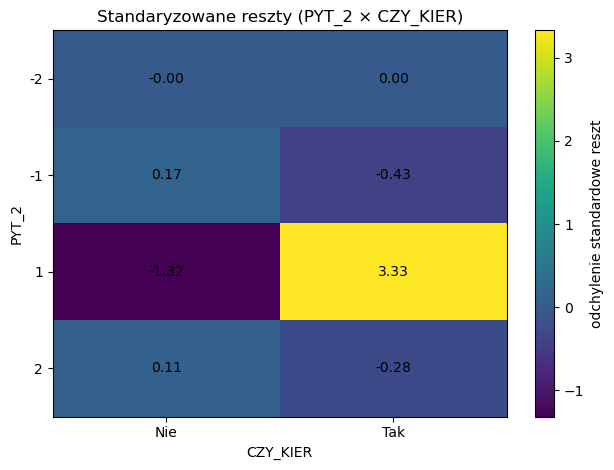

In [ ]:
table = pd.crosstab(df["PYT_2"], df["CZY_KIER"])

chi2, p, dof, expected = stats.chi2_contingency(table, correction=False)

print(f"Chi2 = {chi2:.4f}, p-value = {p:.4f}, df = {dof}")
if p < 0.01:
    print("→ ODRZUCAMY H₀: zadowolenie zależy od stanowiska")
else:
    print("→ Brak podstaw do odrzucenia H₀: zadowolenie niezależne od stanowiska")

residuals = (table - expected) / np.sqrt(expected)

plt.imshow(residuals.values, aspect='auto')

plt.xticks(np.arange(len(table.columns)), table.columns)
plt.yticks(np.arange(len(table.index)), table.index)
plt.xlabel("CZY_KIER")
plt.ylabel("PYT_2")
plt.title("Standaryzowane reszty (PYT_2 × CZY_KIER)")

for i in range(residuals.shape[0]):
    for j in range(residuals.shape[1]):
        plt.text(j, i, f"{residuals.values[i,j]:.2f}", ha="center", va="center")

plt.colorbar(label="odchylenie standardowe reszt")
plt.tight_layout()
plt.show()

Test chi-kwadrat daje $\chi^2(3) = 13,11$ z $p = 0,0044$, co przy $\alpha = 0,01$ pozwala odrzucić $H_0$ o niezależności – poziom zadowolenia (PYT\_2) istotnie różni się między kierownikami a pozostałymi pracownikami. Wynik ten jest zgodny z zadaniem 6.

Patrząc na standaryzowane reszty, największy wkład w tę zależność wnosi komórka „PYT\_2 = 1 (zgadzam się)” w kolumnie „Tak” (reszta $\approx +3,33$), co oznacza, że kierownicy znacząco częściej niż oczekiwano deklarują umiarkowaną zgodę na tezę o dopasowaniu szkoleń. Odwrotnie jest wśród nie-kierowników, którzy w tej samej kategorii wypadają poniżej oczekiwań (reszta $\approx -1,32$). Pozostałe komórki mają niewielkie reszty, więc główny efekt to przewaga kierowników deklarujących zgodę.


___
## Zadanie 9
**Oszacowanie mocy testu Fishera oraz testu chi-kwadrat Pearsona poprzez symulację**

W zadaniu przeprowadzono symulację w celu oszacowania mocy testu Fishera oraz testu chi-kwadrat Pearsona. 

W procesie symulacji:
- Wygenerowano próbki z rozkładu wielomianowego przy zadanych prawdopodobieństwach, dbając o to, aby marginesy wierszy i kolumn w tabeli były większe od zera, co gwarantuje poprawność wyników.
- Dla każdej próby przeprowadzono test Fishera oraz test chi-kwadrat, a wyniki porównano z ustalonym poziomem istotności.
- Obliczono moc testów (procent przypadków, w których test odrzucił hipotezę zerową).

Wyniki zostały przedstawione w tabeli, która pokazuje, jak moc obu testów zmienia się w zależności od rozmiaru próby. 

In [ ]:
def moc_testu(n, p, N=500, alpha=0.05):
    np.random.seed(0)
    count_fisher = 0
    count_chi2 = 0
    
    for _ in range(N):
        while True:
            x = np.random.multinomial(n, p)
            row_sums = [x[0]+x[1], x[2]+x[3]]
            col_sums = [x[0]+x[2], x[1]+x[3]]
            if all(s > 0 for s in row_sums + col_sums):
                break
        
        table = np.array([[x[0], x[1]], [x[2], x[3]]])
        
        _, p_fisher = stats.fisher_exact(table, alternative='two-sided')
        if p_fisher < alpha:
            count_fisher += 1
        
        _, p_chi2, _, _ = stats.chi2_contingency(table, correction=False)
        if p_chi2 < alpha:
            count_chi2 += 1
    
    return count_fisher / N, count_chi2 / N

In [134]:
p = [1/40, 3/40, 19/40, 17/40]
ns = [50, 100, 1000]
results = []

for n in ns:
    pow_f, pow_c = moc_testu(n, p, N=500, alpha=0.05)
    results.append((n, pow_f, pow_c))

df_results = pd.DataFrame(results, columns=['n', 'Power Fisher', 'Power Chi2'])
df_results

,n,Power Fisher,Power Chi2
0,50,0.124,0.198
1,100,0.306,0.384
2,1000,1.000,1.000


Przy bardzo małej próbie ($n = 50$) oba testy mają niską moc, ale test chi-kwadrat ($\approx 0{,}20$) jest nieco bardziej czuły niż dokładny test Fishera ($\approx 0{,}12$). Dla $n = 100$ różnice utrzymują się ($\approx 0{,}38$ vs. $\approx 0{,}31$), choć moc obu rośnie. Natomiast przy $n = 1000$ oba testy osiągają moc praktycznie równą $1$, co oznacza niemal pewność wykrycia tej wielkości efektu.

Generalnie więc: im większa próba, tym większa moc; test chi-kwadrat ma nieco wyższą moc od testu Fishera dla umiarkowanych $n$, ale przy dużych próbkach oba są równie skuteczne.


___
## Zadanie 10
**Obliczenie wartości poziomu krytycznego w teście niezależności opartym na ilorazie wiarogodności**

W zadaniu stworzono funkcję `poziom_krytyczny_lr`, która oblicza wartość poziomu krytycznego w teście niezależności.

Proces obliczeń:
1. Funkcja przyjmuje tabelę 2D z nieujemnymi liczbami całkowitymi, reprezentującą kontyngencję.
2. Na podstawie tej tabeli obliczane są wartości logarytmu ilorazu $\lambda$ (log-likelihood ratio), który jest wykorzystywany do wyznaczenia statystyki $G^2$:

   $$ \log(\lambda) = \sum_{i,j} n_{ij} \left[ \log \left( \frac{n_{i+} n_{+j}}{n \cdot n_{ij}} \right) \right] $$

   gdzie:
   - $n_{ij}$ to liczba obserwacji w komórce tabeli (i, j),
   - $n_{i+}$ to suma elementów w wierszu i,
   - $n_{+j}$ to suma elementów w kolumnie j,
   - $n$ to suma wszystkich obserwacji w tabeli.
   
3. Statystyka $G^2$ jest porównywana z wartością krytyczną, którą oblicza funkcja `chi2.ppf` na podstawie rozkładu chi-kwadrat i liczby stopni swobody (df).

Dla danych z zadania 8 (analiza zależności między stopniem zadowolenia a zajmowanym stanowiskiem) obliczono:
- Statystykę $G^2$,
- Liczbę stopni swobody,
- Wartość krytyczną $G^2$.

Na podstawie tej analizy, w zależności od porównania statystyki $G^2$ z wartością krytyczną, zdecydowano, czy należy odrzucić hipotezę zerową:
- Jeśli $G^2 >$ wartość krytyczna, to odrzucamy hipotezę zerową (zadowolenie zależy od stanowiska).
- Jeśli $G^2 \leq$ wartość krytyczna, brak podstaw do odrzucenia hipotezy zerowej (zadowolenie niezależne od stanowiska).

Wyniki testu pokazują, czy zadowolenie ze szkoleń jest zależne od zajmowanego stanowiska, na poziomie istotności 0.05.

In [ ]:
def poziom_krytyczny_lr(table, alpha=0.05):
    """
    table : 2D array–like z nieujemnymi liczbami całkowitymi (kontyngencja R×C)
    alpha : poziom istotności (domyślnie 0.05)

    Zwraca:
      crit     – wartość graniczna G² , tzn. chi2.ppf(1-alpha, df=(R-1)*(C-1))
      G2_stat  – obliczoną statystykę G² = -2 log λ
      df_       – stopnie swobody = (R-1)*(C-1)
    """
    table = np.asarray(table, dtype=float)
    r, c = table.shape
    n = table.sum()
    row_sums = table.sum(axis=1)
    col_sums = table.sum(axis=0)

    log_lambda = 0.0
    for i in range(r):
        for j in range(c):
            nij = table[i, j]
            if nij > 0:
                log_lambda += nij * (
                    np.log(row_sums[i] * col_sums[j])
                    - np.log(n * nij)
                )

    G2_stat = -2 * log_lambda
    df_ = (r - 1) * (c - 1)
    crit = stats.chi2.ppf(1 - alpha, df_)

    return crit, G2_stat, df_

In [136]:
tab = pd.crosstab(df["PYT_2"], df["CZY_KIER"])  # 4×2

crit, G2, df_ = poziom_krytyczny_lr(tab, alpha=0.05)
print(f"G² = {G2:.4f}, df = {df_}, krytyczne G²_crit = {crit:.4f}")

if G2 > crit:
    print("→ ODRZUCAMY H₀: zadowolenie zależy od stanowiska")
else:
    print("→ Brak podstaw do odrzucenia H₀: zadowolenie niezależne")

G² = 8.3285, df = 3, krytyczne G²_crit = 7.8147
→ ODRZUCAMY H₀: zadowolenie zależy od stanowiska


Statystyka ilorazu wiarygodności wyniosła $G^2 = 8{,}33$ ($df = 3$), a wartość krytyczna przy $\alpha = 0{,}05$ to $7{,}81$, więc $G^2 > G^2_{\text{crit}}$ i odrzucamy $H_0$. Oznacza to, że poziom zadowolenia ze szkoleń istotnie różni się między pracownikami na stanowiskach kierowniczych a pozostałymi, co potwierdza wniosek z wcześniejszego testu chi-kwadrat i testu Fishera.


___
# Część IV oraz V
___
## Zadanie 11
**Zadanie 11**
**Analiza związku między paleniem papierosów a przyczynami zgonu z wykorzystaniem miar siły zależności**

W zadaniu obliczono trzy miary siły związku między paleniem papierosów a zgonami z powodu raka płuc oraz choroby niedokrwiennej serca. Wykorzystano następujące wskaźniki:

* **Różnica proporcji (RP)** — wyraża bezwzględną różnicę prawdopodobieństw wystąpienia zdarzenia między grupami (palacze − niepalacze).
* **Ryzyko względne (RR)** — stosunek prawdopodobieństwa zgonu w grupie palaczy do prawdopodobieństwa zgonu w grupie niepalaczy.
* **Iloraz szans (OR)** — stosunek szans zgonu w grupie palaczy do szans w grupie niepalaczy.

Dla każdej przyczyny zgonu (rak płuc, choroba serca) obliczono powyższe miary, korzystając ze znanych wartości odsetków zgonów w grupie palaczy i niepalaczy.

In [ ]:
pluca_palacze = 0.00140
pluca_niepalacze = 0.00010
serce_palacze = 0.00669
serce_niepalacze = 0.00413

def compute_metrics(p1, p2):
    rp = p1 - p2
    rr = p1 / p2
    or_ = (p1 / (1 - p1)) / (p2 / (1 - p2))
    return rp, rr, or_

results = []
for outcome, p1, p2 in [
    ("Rak płuc", pluca_palacze, pluca_niepalacze),
    ("Choroba serca", serce_palacze, serce_niepalacze),
]:
    rp, rr, or_ = compute_metrics(p1, p2)
    results.append({
        "Wynik": outcome,
        "p (palacze)": p1,
        "p (niepalacze)": p2,
        "RP": rp,
        "RR": rr,
        "OR": or_,
    })

df = pd.DataFrame(results)
df

,Wynik,p (palacze),p (niepalacze),RP,RR,OR
0,Rak płuc,0.00140,0.00010,0.00130,14.000000,14.018226
1,Choroba serca,0.00669,0.00413,0.00256,1.619855,1.624029


Choć różnica proporcji jest większa dla choroby serca, to miary RR i OR pokazują dużo silniejszy związek palenia ze śmiercią na raka płuc. Zatem na miarę siły efektu – palenie jest znacznie mocniej skojarzone ze zwiększonym ryzykiem zgonu z powodu raka płuc niż z powodu choroby wieńcowej.

___
## Zadanie 12
**Analiza związku między używaniem pasów bezpieczeństwa a śmiertelnością w wypadkach samochodowych**

W zadaniu przeanalizowano dane dotyczące wypadków samochodowych na Florydzie w 2008 roku, uwzględniając śmiertelność oraz użycie pasów bezpieczeństwa. Wykonano następujące kroki:

a) Oszacowano warunkowe prawdopodobieństwa śmierci w wypadku, osobno dla osób używających i nieużywających pasów bezpieczeństwa.

b) Oszacowano warunkowe prawdopodobieństwa użycia pasów bezpieczeństwa, osobno dla osób, które zginęły, oraz dla osób, które przeżyły wypadek.

c) Obliczono trzy miary siły związku między użyciem pasów a śmiertelnością

Obliczenia pozwalają na ocenę zależności między stosowaniem pasów bezpieczeństwa a ryzykiem śmierci w wypadkach drogowych.

### a) i b)

In [ ]:
zmarli_bez = 1085
zywi_bez = 55623
zmarli_pas = 703
zywi_pas = 441239

pi_1_1 = zmarli_bez / (zmarli_bez + zywi_bez)
pi_1_2 = zmarli_pas / (zmarli_pas + zywi_pas)

pi_2_1 = zmarli_pas / (zmarli_pas + zmarli_bez)
pi_2_2 = zywi_pas / (zywi_pas + zywi_bez)

df = pd.DataFrame([
    {
        "Warunek": "Śmierć | Bez pasów",
        "Prawdopodobieństwo": pi_1_1
    },
    {
        "Warunek": "Śmierć | Z pasami",
        "Prawdopodobieństwo": pi_1_2
    },
    {
        "Warunek": "Pasy | Zgon",
        "Prawdopodobieństwo": pi_2_1
    },
    {
        "Warunek": "Pasy | Przeżycie",
        "Prawdopodobieństwo": pi_2_2
    }
])

df

,Warunek,Prawdopodobieństwo
0,Śmierć | Bez pasów,0.019133
1,Śmierć | Z pasami,0.001591
2,Pasy | Zgon,0.393177
3,Pasy | Przeżycie,0.888051


Użycie pasów zmniejsza prawdopodobieństwo śmierci z $\approx 1{,}91\%$
 do $\approx 0{,}16\%$, a osoby, które zginęły, nosiły pasy w $\approx 39\%$ przypadków, podczas gdy spośród tych, którzy przeżyli wypadek, aż $\approx 89\%$ było w pasach.

### c)

Najbardziej naturalną zmienną objaśnianą w tym badaniu jest zgon w wypadku, a jako zmienną objaśniającą – użycie pasa. 

In [ ]:
no = zmarli_bez / (zmarli_bez + zywi_bez)
yes = zmarli_pas / (zmarli_pas + zywi_pas)

def compute_metrics(p1, p2):
    rp = p1 - p2
    rr = p1 / p2
    or_ = (p1 / (1 - p1)) / (p2 / (1 - p2))
    return rp, rr, or_

rp, rr, or_ = compute_metrics(no, yes)

df = pd.DataFrame([{
    "Metryka": ["RP", "RR", "OR"],
    "Wartość": [rp, rr, or_]
}]).explode(["Metryka","Wartość"]).reset_index(drop=True)

df

,Metryka,Wartość
0,RP,0.017542
1,RR,12.028054
2,OR,12.24317


Kierowca czy pasażer, który nie zapiął pasa, ma o około 1,75 punktu procentowego wyższe ryzyko śmierci, a jego względne ryzyko (RR) i iloraz szans (OR) zgonu są ~12-krotnie większe. Wartości RR i OR są bardzo zbliżone, ponieważ zgon w wyniku wypadku to zdarzenie stosunkowo rzadkie (p ≪ 1), a dla rzadkich zdarzeń szanse zbliżają się do prawdopodobieństw.

___
## Zadanie 13

In [ ]:
def tau(tabela):
    tabela = np.array(tabela)
    suma_wierszy = np.sum(tabela, axis=1)
    suma_kolumn = np.sum(tabela, axis=0)
    n = np.sum(tabela)
    r = len(suma_wierszy)
    c = len(suma_kolumn)
    suma = 0
    for i in range(r):
        for j in range(c):
            suma += tabela[i, j]**2 / (n * suma_wierszy[i])
    mianownik = 1 - sum((suma_kolumn / n)**2)
    licznik = suma - sum((suma_kolumn / n)**2)
    return licznik / mianownik

def gamma(tabela):
    tabela = np.array(tabela)
    r = len(tabela)
    c = len(tabela[0])
    C = 0
    D = 0
    for i in range(r - 1):
        for j in range(c - 1):
            C += tabela[i, j] * np.sum(tabela[i + 1:, j + 1:])
    for i in range(r - 1, 0, -1):
        for j in range(c - 1):
            D += tabela[i, j] * np.sum(tabela[:i, j + 1:])
    return (C - D) / (C + D) if (C + D) != 0 else 0

df = pd.read_csv("ankieta.csv", sep=";", encoding="Latin2")

ct1 = pd.crosstab(df["PYT_2"], df["CZY_KIER"])
ct2 = pd.crosstab(df["PYT_2"], df["STAŻ"])
ct3 = pd.crosstab(df["CZY_KIER"], df["STAŻ"])

wyniki = []
for nazwa, ct in [("PYT_2 vs CZY_KIER", ct1),
                  ("PYT_2 vs STAŻ", ct2),
                  ("CZY_KIER vs STAŻ", ct3)]:
    wyniki.append({
        "Para zmiennych": nazwa,
        "Tau": tau(ct),
        "Gamma": gamma(ct)
    })

wyniki_df = pd.DataFrame(wyniki)
wyniki_df


,Para zmiennych,Tau,Gamma
0,PYT_2 vs CZY_KIER,0.065568,-0.034139
1,PYT_2 vs STAŻ,0.052137,0.090843
2,CZY_KIER vs STAŻ,0.030594,0.752653


Zarówno $\tau \approx 0{,}066$ jak i prawie zerowa $\gamma \approx -0{,}034$ dla pary PYT_2 vs CZY\_KIER wskazują na praktycznie brak monotonicznej zależności między poziomem satysfakcji a pełnieniem funkcji kierowniczej. Między satysfakcją a stażem ($\tau \approx 0{,}052$, $\gamma \approx 0{,}091$) widać już niewielką, ale dodatnią relację – dłuższy staż wiąże się nieznacznie z wyższymi ocenami. Najsilniejszy porządkowy związek zachodzi jednak między stażem a zajmowaniem stanowiska kierowniczego: mimo że $\tau$ jest niewielkie ($\approx 0{,}031$), $\gamma \approx 0{,}75$ pokazuje, iż zdecydowana większość par jest zgodna – im dłuższy staż, tym większe prawdopodobieństwo pełnienia roli menedżera.


___
## Zadanie 14

In [ ]:

def correspondence_analysis(table, dim=2, figsize=(12,6)):
    """
    Analiza korespondencji dla tabeli kontyngencji.
    Zwraca słownik z:
      - row_masses, col_masses        : masy wierszy i kolumn
      - row_profiles, col_profiles    : profile wierszy i kolumn
      - residual_matrix                : macierz reszt ustandaryzowanych
      - singular_values               : wartości osobliwe (Sigma)
      - inertia, inertia_ratio        : inercja i procentowy udział wymiarów
      - row_coords, col_coords        : współrzędne punktów w pierwszych wymiarach
    Dodatkowo rysuje biplot głównych wymiarów z wyraźnymi etykietami.

    table   : DataFrame lub 2D-array (R×C) z nieujemnymi licznościami
    dim     : liczba wymiarów do wyciągnięcia (domyślnie 2)
    figsize : rozmiar wykresu (szer. x wys.)
    """
    # 1) Konwersja do macierzy i obliczenia wag
    T = np.array(table, dtype=float)
    n = T.sum()
    r, c = T.shape

    row_m = T.sum(axis=1) / n
    col_m = T.sum(axis=0) / n
    row_profiles = T / T.sum(axis=1)[:, None]
    col_profiles = T / T.sum(axis=0)[None, :]

    # 2) Macierz reszt ustandaryzowanych
    E = (T / n) - np.outer(row_m, col_m)
    S = E / np.sqrt(np.outer(row_m, col_m))

    # 3) Rozkład SVD
    U, s, Vt = np.linalg.svd(S, full_matrices=False)
    inertia = s**2
    inertia_ratio = inertia / inertia.sum()

    # 4) Współrzędne punktów (principal coordinates)
    Dr_inv_sqrt = np.diag(1/np.sqrt(row_m))
    Dc_inv_sqrt = np.diag(1/np.sqrt(col_m))
    F = Dr_inv_sqrt @ U[:, :dim] @ np.diag(s[:dim])
    G = Dc_inv_sqrt @ Vt[:dim, :].T @ np.diag(s[:dim])

    # 5) Biplot z wyraźnymi etykietami
    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(F[:,0], F[:,1], color='C0', s=100, label='wiersze')
    ax.scatter(G[:,0], G[:,1], color='C1', s=100, marker='s', label='kolumny')

    # Etykiety wierszy
    for i, lbl in enumerate(table.index):
        ax.text(
            F[i,0], F[i,1] + (inertia_ratio[1] * 0.5), str(lbl),
            ha='center', va='bottom', fontsize=12, fontweight='bold', color='C0',
            bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.8)
        )
    # Etykiety kolumn
    for j, lbl in enumerate(table.columns):
        ax.text(
            G[j,0], G[j,1] + (inertia_ratio[1] * 0.5), str(lbl),
            ha='center', va='bottom', fontsize=12, fontweight='bold', color='C1',
            bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.8)
        )

    ax.axhline(0, color='gray', lw=1)
    ax.axvline(0, color='gray', lw=1)
    ax.set_xlabel(f"D1 ({inertia_ratio[0]*100:.1f}% inercji)")
    ax.set_ylabel(f"D2 ({inertia_ratio[1]*100:.1f}% inercji)")
    ax.set_title("Analiza korespondencji – główne wymiary")
    ax.legend()
    plt.tight_layout()
    plt.show()

    return {
        'row_masses': row_m,
        'col_masses': col_m,
        'row_profiles': row_profiles,
        'col_profiles': col_profiles,
        'residual_matrix': S,
        'singular_values': s,
        'inertia': inertia,
        'inertia_ratio': inertia_ratio,
        'row_coords': F,
        'col_coords': G
    }



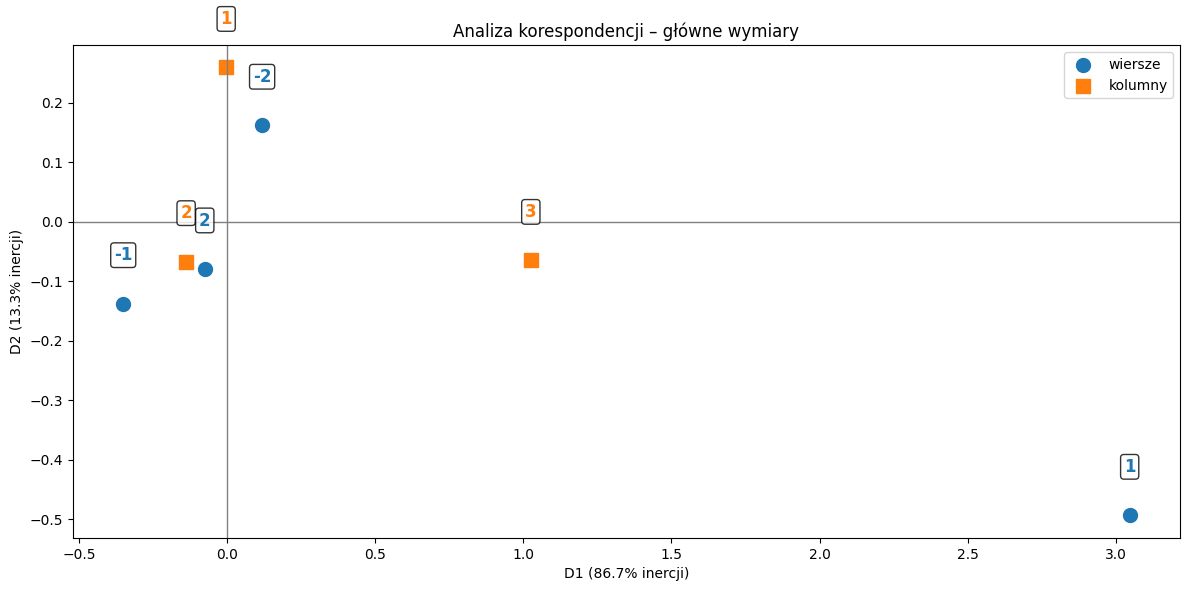

{'row_masses': array([0.37, 0.1 , 0.01, 0.52]),
 'col_masses': array([0.205, 0.7  , 0.095]),
 'row_profiles': array([[0.27027027, 0.60810811, 0.12162162],
        [0.15      , 0.85      , 0.        ],
        [0.        , 0.        , 1.        ],
        [0.17307692, 0.75      , 0.07692308]]),
 'col_profiles': array([[0.48780488, 0.32142857, 0.47368421],
        [0.07317073, 0.12142857, 0.        ],
        [0.        , 0.        , 0.10526316],
        [0.43902439, 0.55714286, 0.42105263]]),
 'residual_matrix': array([[ 0.08768783, -0.06680809,  0.052538  ],
        [-0.03841367,  0.05669467, -0.09746794],
        [-0.04527693, -0.083666  ,  0.29362077],
        [-0.0508428 ,  0.04309458, -0.0422926 ]]),
 'singular_values': array([3.36512155e-01, 1.31742699e-01, 3.99699189e-17]),
 'inertia': array([1.13240431e-01, 1.73561387e-02, 1.59759441e-33]),
 'inertia_ratio': array([8.67101113e-01, 1.32898887e-01, 1.22330504e-32]),
 'row_coords': array([[ 0.11826617,  0.16222748],
        [-0.350

In [22]:
ct = pd.crosstab(df["PYT_2"], df["STAŻ"])

res = correspondence_analysis(ct, dim=2)
res